*Post updated 6.11.2016 to reflect changes to the parameter names*

Quite a while ago I did a [blog post](http://rdkit.blogspot.co.at/2015/08/tuning-substructure-queries.html) describing a method to exert more control over the way substructure queries match. The approach described in that post was integrated into the RDKit for the 2015.09 release; since then it's been expanded a bit.

This post shows how to use the approach from Python and directly within the RDKit PostgreSQL cartridge. Note that, as usual, I am using a development version of the RDKit, so a fair amount of the functionality I demo here is new/changed relative to the 2016.03 release. 

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
%load_ext sql
print(rdBase.rdkitVersion)
import time
print(time.asctime())

/Users/glandrum/anaconda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/glandrum/anaconda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


2016.09.1.b1
Sun Nov  6 05:51:14 2016


# Adjusting queries in the cartridge

Our starting point is a query against ChEMBL for molecules that contain a pyridine ring.

10 rows affected.


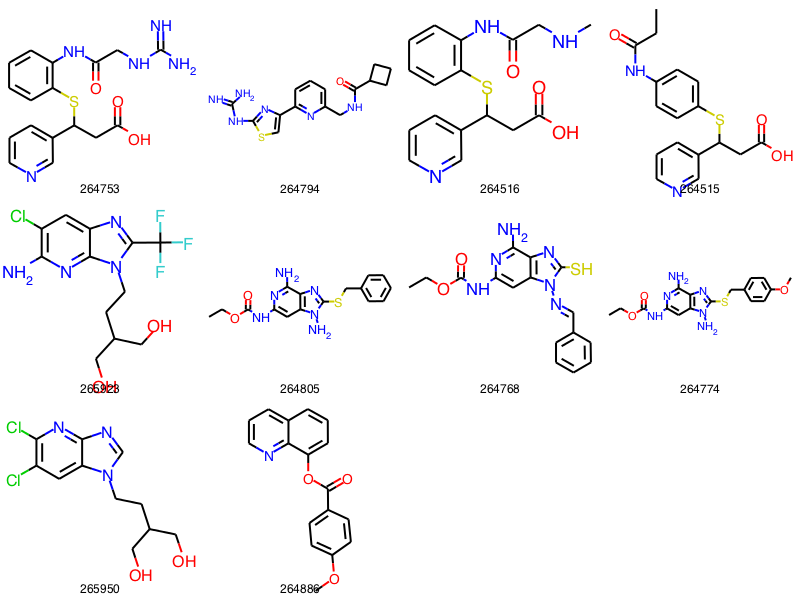

In [2]:
data = %sql postgresql://localhost/chembl_21 \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>'c1ccccn1' limit 10;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)

If we add two dummy atoms to that in order to look for 2-6 di-substituted pyridines we initially get no results:

In [3]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>'*c1cccc(*)n1' limit 10 ;

0 rows affected.


But we can change that by calling the new `mol_adjust_query_properties()` function:

10 rows affected.


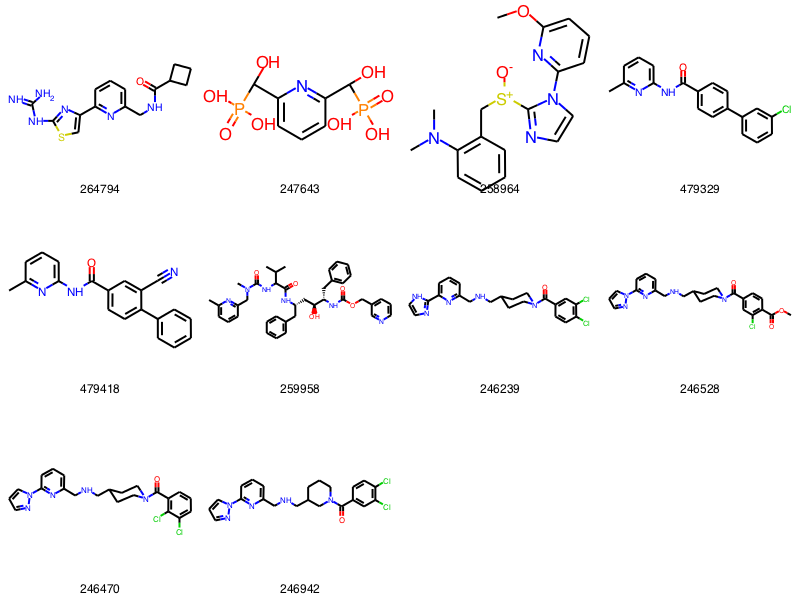

In [4]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

This function makes a number of changes by default:

  - Converts dummy atoms into "any" queries
  - Adds a degree query to every ring atom so that its substitution must match what was provided
  - Aromaticity perception is done (if it hasn't been done already)
  
The addition of degree queries has the consequence that we only find di-substituted pyridines. We can lift that restriction by providing some additional configuration information to `mol_adjust_query_properties()` as JSON:

10 rows affected.


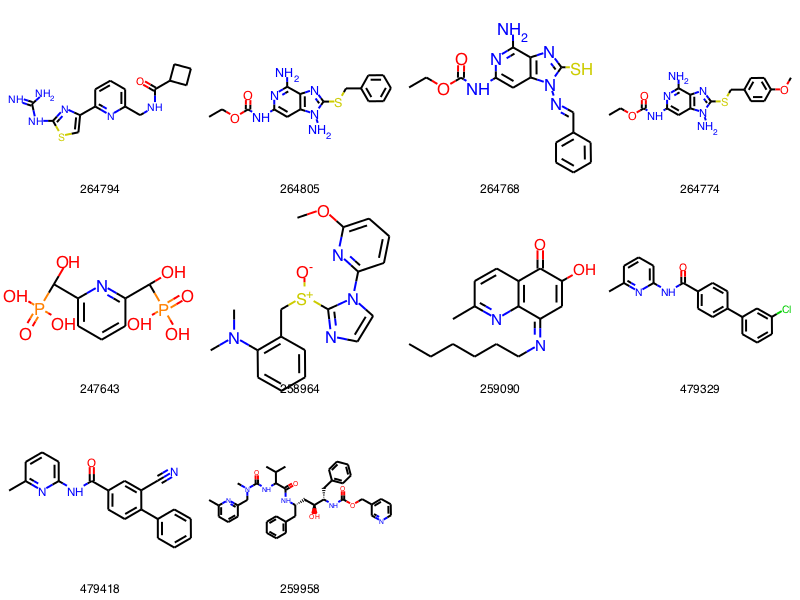

In [5]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1',\
                                                         '{"adjustDegree"\:false}') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

Notice that now we have additional substitution options on the rings. However now there are also some examples where the pyridine is part of a fused ring. We can get rid of these by telling `mol_adjust_query_properties()` to also add a ring-count query to every ring atom :

10 rows affected.


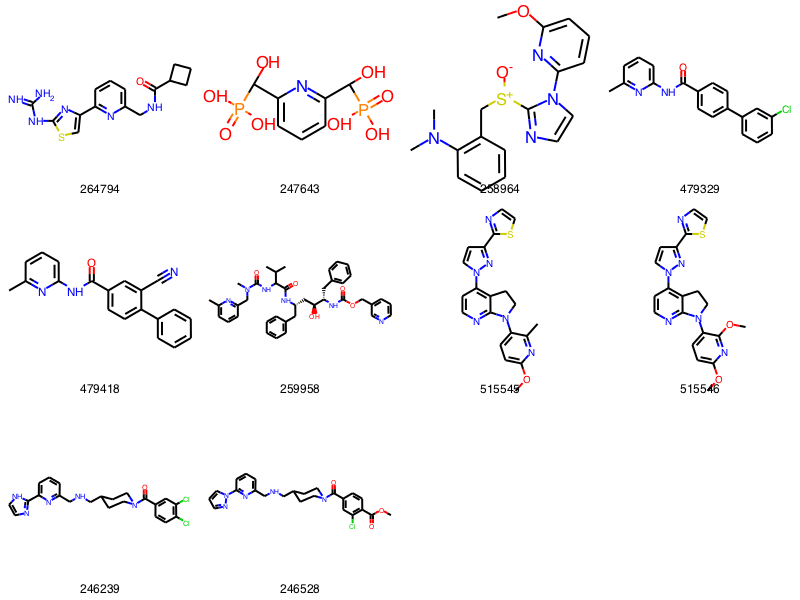

In [6]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(*)n1',\
                                                         '{"adjustDegree"\:false,\
                                                          "adjustRingCount"\:true}') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

To explore the next set of options, we extend the query a little bit to search for 2-6 substituted pyridines where one of the substituents starts with an `NC=O`:

10 rows affected.


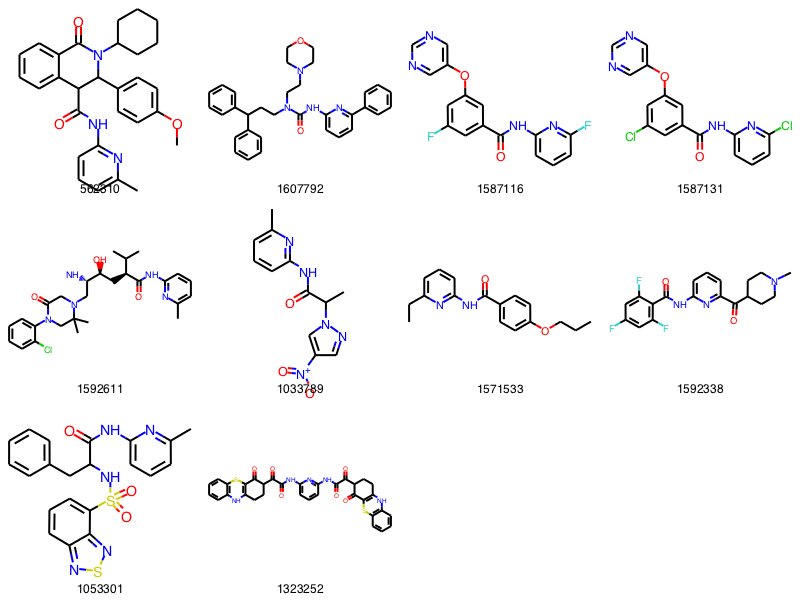

In [7]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

Let's allow the degrees of ring atoms or dummies to change, but not the degree of chain atoms, this should remove matches like those to molecule 952459 above:

10 rows affected.


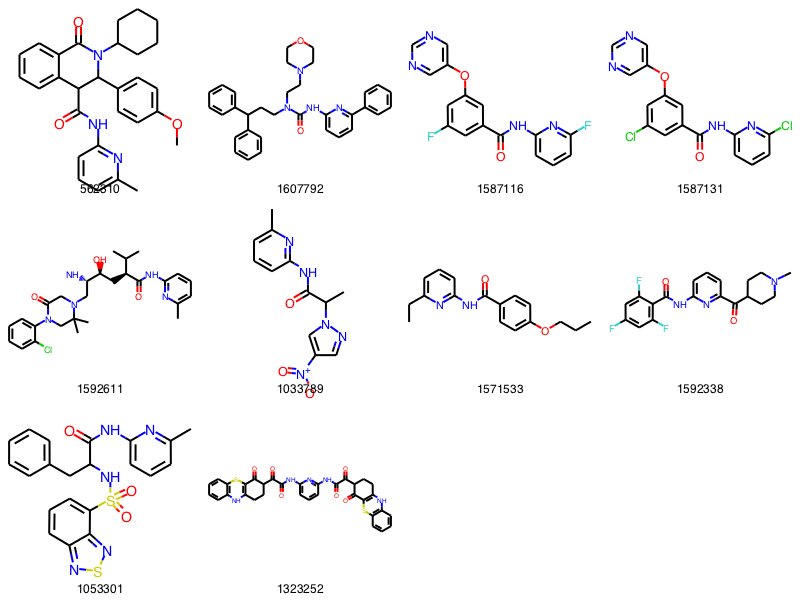

In [9]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1',\
                                                         '{"adjustDegree"\:true,\
                                                          "adjustDegreeFlags"\:"IGNORERINGS|IGNOREDUMMIES"\
                                                          }') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

And now get rid of the fused rings by turning on the ring-count changes too:

10 rows affected.


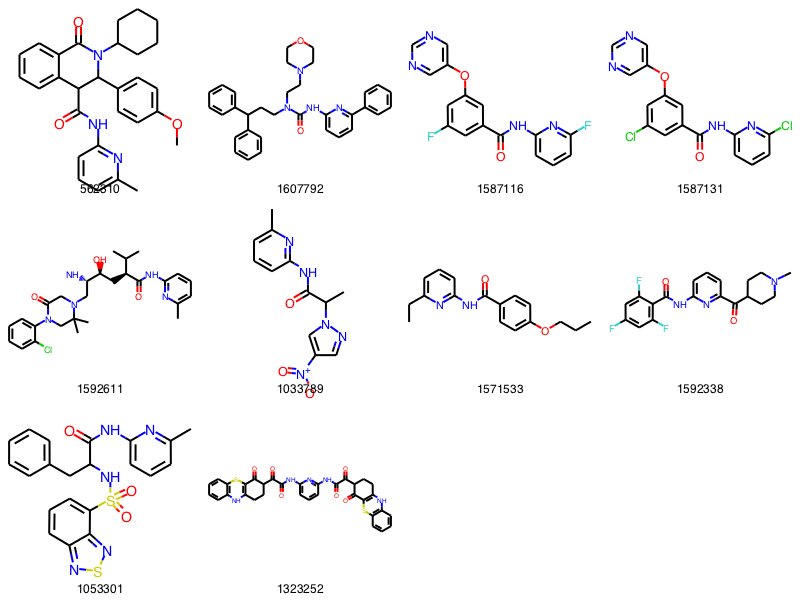

In [10]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1',\
                                                         '{"adjustDegree"\:true,\
                                                          "adjustDegreeFlags"\:"IGNORERINGS|IGNOREDUMMIES",\
                                                          "adjustRingCount"\:true}') limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

The same adjustments can be used on query molecules constructed from mol blocks:

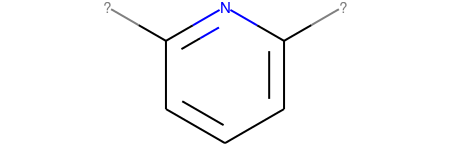

In [11]:
mb="""
  Mrv1561 07261609522D          

  8  8  0  0  0  0            999 V2000
   -1.9866    0.7581    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7011    0.3455    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7011   -0.4795    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.9866   -0.8920    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2721   -0.4795    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2721    0.3455    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.4155    0.7580    0.0000 A   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5577    0.7580    0.0000 A   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  1  6  2  0  0  0  0
  2  3  2  0  0  0  0
  3  4  1  0  0  0  0
  4  5  2  0  0  0  0
  5  6  1  0  0  0  0
  2  7  1  0  0  0  0
  6  8  1  0  0  0  0
M  END
"""
Chem.MolFromMolBlock(mb)

The semantics of mol block queries are a bit different since we already have query atoms:

10 rows affected.


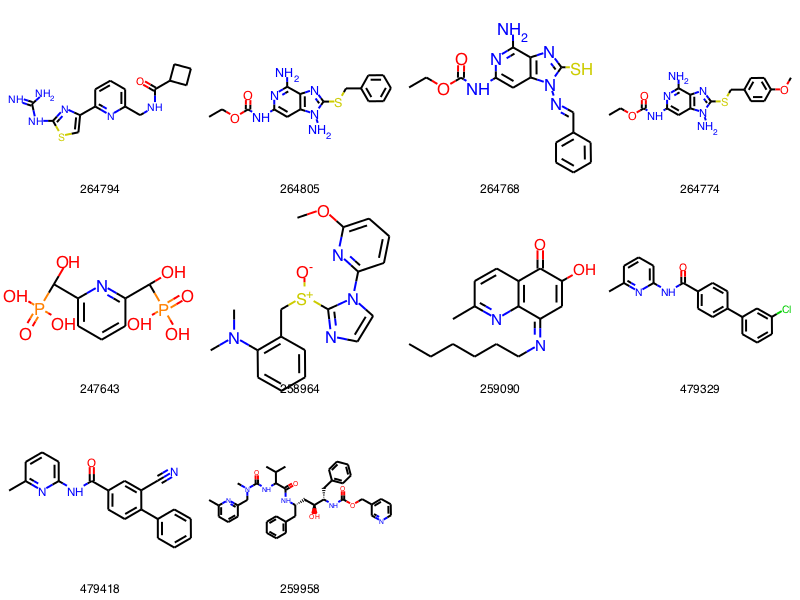

In [12]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_from_ctab(:mb) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

Calling `mol_adjust_query_properties()` here effectively just adds the degree queries (since the dummies are already queries), providing the same results as in Block 4 above:

10 rows affected.


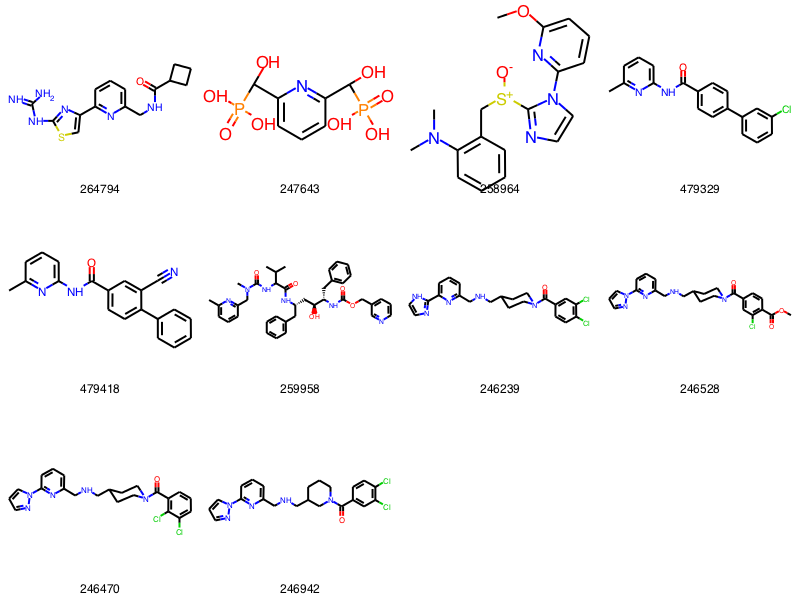

In [13]:
data = %sql \
    select molregno,molfile from rdk.mols join compound_structures \
    using (molregno) where m@>mol_adjust_query_properties(mol_from_ctab(:mb)) limit 10 ;
mols = [Chem.MolFromMolBlock(y) for x,y in data]
Draw.MolsToGridImage(mols,legends=[str(x) for x,y in data],molsPerRow=4)    

# Using that from Python

The same options are available from Python using the function `Chem.AdjustQueryProperties()`:

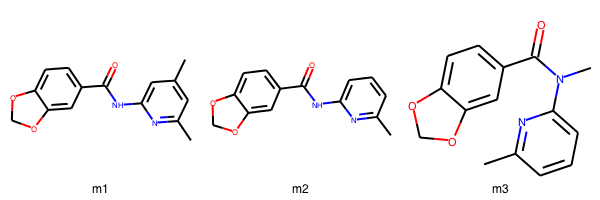

In [14]:
m1 = Chem.MolFromSmiles('Cc1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m2 = Chem.MolFromSmiles('c1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m3 = Chem.MolFromSmiles('c1cc(C)nc(N(C)C(=O)c2ccc3c(c2)OCO3)c1')
Draw.MolsToGridImage((m1,m2,m3),legends=['m1','m2','m3'])

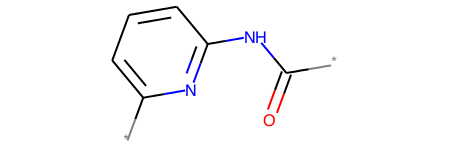

In [15]:
q = Chem.MolFromSmiles('*c1cccc(NC(=O)*)n1')
q

Initially this has no substructure matches since the dummy atoms can't match anything:

In [16]:
m1.HasSubstructMatch(q),m2.HasSubstructMatch(q),m3.HasSubstructMatch(q)

(False, False, False)

The defaults to `Chem.AdjustQueryProperties()` take care of this, but they also exclude the match to m1 due to the degree queries added to ring atoms:

In [17]:
tq = Chem.AdjustQueryProperties(q)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(False, True, True)

Turn off the degree queries and all the molecules match:

In [18]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=False
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, True)

We can also use the degree query only on chain atoms, this disables the match of m3:

In [19]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=True
params.adjustDegreeFlags=Chem.ADJUST_IGNORERINGS|Chem.ADJUST_IGNOREDUMMIES
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, False)